# practicalMixGauss_Apples

In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import os 
import scipy.io as spio

from numpy import sqrt, pi, exp, transpose, matmul
from numpy.linalg import det, inv

from scipy.stats import norm 
from scipy.stats import multivariate_normal
import time
import sys

flt_min = sys.float_info.min

%matplotlib notebook

# Load training color images

In [2]:
files = glob.glob("apples/*.jpg")
ColorImgs = []
for myFile in files:
    im = plt.imread(myFile)
    im=im/255
    # im is now a double-precision 3D matrix of size (width x height x 3). 
    # Each of the 3 color channels is now in the range [0.0, 1.0].
    ColorImgs.append(im)

# Load training mask images

In [3]:
files = glob.glob("apples/*.png")
MaskImgs = []
for myFile in files:
    im = plt.imread(myFile)
    # Picked green-channel arbitrarily.
    im=im[:,:,1]
    MaskImgs.append(im)

# Load first_testing color images

In [4]:
files = glob.glob("testApples/*.jpg")
ColorTestImgs = []
for myFile in files:
    im = plt.imread(myFile)
    im=im/255
    # im is now a double-precision 3D matrix of size (width x height x 3). 
    # Each of the 3 color channels is now in the range [0.0, 1.0].
    ColorTestImgs.append(im)

# Load first_testing mask images

In [5]:
files = glob.glob("testApples/*.png")
MaskTestImgs = []
for myFile in files:
    im = plt.imread(myFile)
    # Picked green-channel arbitrarily.
    im=im[:,:,1]
    MaskTestImgs.append(im)

# Load second_testing color images

In [6]:
files = glob.glob("test2Apples/*.jpg")
ColorTest2Imgs = []
for myFile in files:
    im = plt.imread(myFile)
    im=im/255
    # im is now a double-precision 3D matrix of size (width x height x 3). 
    # Each of the 3 color channels is now in the range [0.0, 1.0].
    ColorTest2Imgs.append(im)

# Load second_testing mask images

In [7]:
files = glob.glob("test2Apples/*.png")
MaskTest2Imgs = []
for myFile in files:
    im = plt.imread(myFile)
    # Picked green-channel arbitrarily.
    im=im[:,:,1]
    MaskTest2Imgs.append(im)

# Generate training data

In [8]:
RGBApples=[]
RGBNonApples=[]
cOfApplePixels=0
cOfNonApplePixels=0
# Fill the training arrays RGBApples and RGBNonApples.
for i in range(len(ColorImgs)):
    a,b,c = ColorImgs[i].shape
    for m in range(a):
        for n in range(b):
            temp=ColorImgs[i][m,n,:]
            # Black pixels indicate locations where the corresponding photo is non apple
            if MaskImgs[i][m,n]==0.0:
                RGBNonApples.append(temp)
                cOfNonApplePixels+=1
            # White pixels indicate locations where the corresponding photo is an apple
            else:
                RGBApples.append(temp)
                cOfApplePixels+=1
                
RGBApples=np.array(RGBApples).T
RGBNonApples=np.array(RGBNonApples).T

# Train model-estimate MoG using the E-M Algorithm

In [9]:
def fitMixGauss(data, k):
    """
    Estimate a k MoG model that would fit the data. Incremently plots the outcome.
               
    
    Keyword arguments:
    data -- d by n matrix containing data points.
    k -- scalar representing the number of gaussians to use in the MoG model.
    
    Returns: 
    mixGaussEst -- dict containing the estimated MoG parameters.
    
    """
    
    #     MAIN E-M ROUTINE  
    #     In the E-M algorithm, we calculate a complete posterior distribution over                                  
    #     the (nData) hidden variables in the E-Step.  
    #     In the M-Step, we update the parameters of the Gaussians (mean, cov, w).   
    
    nDims, nData = data.shape


    postHidden = np.zeros(shape=(k, nData))

    # we will initialize the values to random values
    mixGaussEst = dict()
    mixGaussEst['d'] = nDims
    mixGaussEst['k'] = k
    mixGaussEst['weight'] = (1 / k) * np.ones(shape=(k))
    mixGaussEst['mean'] = 2 * np.random.randn(nDims, k)
    mixGaussEst['cov'] = np.zeros(shape=(nDims, nDims, k))
    for cGauss in range(k):
        mixGaussEst['cov'][:, :, cGauss] = 2.5 + 1.5 * np.random.uniform() * np.eye(nDims)

    nIter = 10;

    for cIter in range(nIter):
        print('cIter ',cIter,'\n')
        
        # ===================== =====================
        # Expectation Step
        # ===================== =====================
        for cData in range(nData):
            # Calculate posterior probability that this data point came from each of the Gaussians
            # r(ik) is the responsibility or posterior probability of each data point of each Gaussian model. 
            # We will call this responsibility of the kth Gaussian for ith data point.(Slide 7(p26))
            thisData = data[:, cData]
            likeSum=0
            for i in range(k):
                like_former = 1.0 / (pow(2.0 * np.pi, mixGaussEst['d'] / 2.0) * pow(np.linalg.det(mixGaussEst['cov'][:, :, i]), 1.0 / 2.0))
                like_latter = np.exp(-0.5 * np.transpose(thisData - mixGaussEst['mean'][:, i]) @ np.linalg.pinv(mixGaussEst['cov'][:, :, i]) @ (thisData - mixGaussEst['mean'][:, i]))
                likeSum+= mixGaussEst['weight'][i] * like_former * like_latter
            for i in range(k):
                like_former = 1.0 / (pow(2.0 * np.pi, mixGaussEst['d'] / 2.0) * pow(np.linalg.det(mixGaussEst['cov'][:, :, i]), 1.0 / 2.0))
                like_latter = np.exp(-0.5 * np.transpose(thisData - mixGaussEst['mean'][:, i]) @ np.linalg.pinv(mixGaussEst['cov'][:, :, i]) @ (thisData - mixGaussEst['mean'][:, i]))
                postHidden[i, cData] = (mixGaussEst['weight'][i] * like_former * like_latter)/(likeSum)
            

        # ===================== =====================
        # Maximization Step
        # ===================== =====================
        # for each constituent Gaussian
        for cGauss in range(k):
            # Update weighting parameters mixGauss.weight based on 
            # the total posterior probability associated with each Gaussian.
            # In slides 7(p27).
            mixGaussEst['weight'][cGauss] = postHidden[cGauss,:].sum()/postHidden.sum()
            
            
            # Update mean parameters mixGauss.mean by weighted average 
            # where weights are given by posterior probability associated with Gaussian.
            rx=0
            for cData in range(nData):
                rx+=postHidden[cGauss][cData]*data[:, cData]
            mixGaussEst['mean'][:,cGauss] = rx/postHidden[cGauss,:].sum()
            
            
            # Update covarance parameter based on weighted average of square distance from update mean,
            # where weights are given by posterior probability associated with Gaussian.
            rxu=0
            for cData in range(nData):
                rxu+=postHidden[cGauss][cData]*np.mat(data[:,cData ]-mixGaussEst['mean'][:,cGauss]).T@np.mat(data[:, cData]-mixGaussEst['mean'][:,cGauss])
            mixGaussEst['cov'][:,:,cGauss] = rxu/postHidden[cGauss,:].sum()

    return mixGaussEst

# Use train model to estimate weights, means and convariances

In [10]:
# Set number of gaussians for each MoG
k=2
# We have training data for apple and non-apple now.
# We can use fitMixGauss function to estimate weights, means and convariances for each MoG
ApplemixGaussEst = fitMixGauss(RGBApples,k)
NonApplemixGaussEst =fitMixGauss(RGBNonApples,k)

cIter  0 

cIter  1 

cIter  2 

cIter  3 

cIter  4 

cIter  5 

cIter  6 

cIter  7 

cIter  8 

cIter  9 

cIter  0 

cIter  1 

cIter  2 

cIter  3 

cIter  4 

cIter  5 

cIter  6 

cIter  7 

cIter  8 

cIter  9 



# Multivariate Normal Distribution-Calculate likelihood

In [11]:
def calcGaussianProb(data, mixGaussEst):
    """
    Calculate likelihood for a column of data under a mixture of Gaussians model.
    
    Keyword arguments:
    data -- d by 1 vector containing data points.
    mixGaussEst -- dict containing the mixture of gaussians parameters.

    Returns: 
    Like -- scalar containing the likelihood.
    
    """
    # Calculate likelihood of this data point under mixture of Gaussians model.
    # Multivariate Normal Distribution: Pr(x)=Normx[gaussMean,gaussCov]
    like = 0
    for i in range(mixGaussEst['k']):
        like_former = 1.0 / (pow(2.0 * np.pi, mixGaussEst['d'] / 2.0) * pow(np.linalg.det(mixGaussEst['cov'][:, :, i]), 1.0 / 2.0))
        like_latter = np.exp(-0.5 * np.transpose(data - mixGaussEst['mean'][:, i]) @ np.linalg.inv(mixGaussEst['cov'][:, :, i]) @ (data - mixGaussEst['mean'][:, i]))
        like+=mixGaussEst['weight'][i] * like_former * like_latter                                                                                                                                                          
    return  like                                                                     
                                                                                                       

# Calculate posterior probability and display results-apples

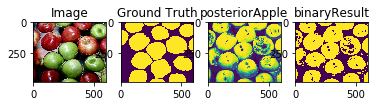

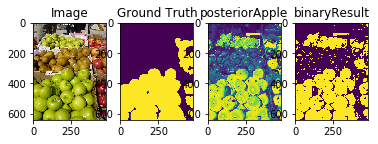

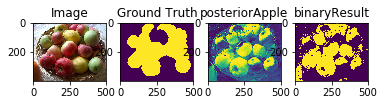

In [12]:
for i in range (len(ColorImgs)):
    # Now run through the pixels in the image and classify them as being apple or
    # non apple - we will fill in the posterior
    priorApple =cOfApplePixels/(cOfApplePixels+cOfNonApplePixels)
    priorNonApple =cOfNonApplePixels/(cOfApplePixels+cOfNonApplePixels)
    imY, imX, imZ = ColorImgs[i].shape
    posteriorApple = np.zeros((imY,imX))
    # In order to get a binary result image.
    binary=np.copy(posteriorApple)

    for cY in range(imY): 
        for cX in range(imX):
            # Extract this pixel's data
            thisPixelData = np.double(ColorImgs[i][cY,cX,:])
        
            # Calculate likelihood of this data given apple model
            likeApple = calcGaussianProb(thisPixelData,ApplemixGaussEst);
            # Calculate likelihood of this data given non apple model
            likeNonApple = calcGaussianProb(thisPixelData,NonApplemixGaussEst);
        
        
            # Calculate posterior probability from likelihoods and priors using BAYES rule.
            # BAYES rule: Posterior=(Likelihood*Prior)/Evidence
            posteriorApple[cY][cX]=(likeApple*priorApple)/(likeApple*priorApple+likeNonApple*priorNonApple)
            # If posteriorApple > 0.5, it means the position is the location of apple. So we change the value to 1.
            # If posteriorApple <= 0.5, it means the position is not the location of apple. So we change the value to 0.
            if posteriorApple[cY][cX]>0.5:
                binary[cY][cX]=1
            if posteriorApple[cY][cX]<=0.5:
                binary[cY][cX]=0
    
    # Set up plots
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
    # show the image
    ax1.imshow(ColorImgs[i])
    ax1.set_title('Image')
    # Show the ground truth mask
    ax2.imshow(MaskImgs[i])
    ax2.set_title('Ground Truth')
    # Show our prediction
    ax3.imshow(posteriorApple)
    ax3.set_title('posteriorApple')
    # Show binary result
    ax4.imshow(binary)
    ax4.set_title('binaryResult')

In [13]:
# The first image is the original image, and the second image is ground truth image which just brighten 
# the apple. The third iamge is posterior image which aims to brighten the apple and darken other things
# and the fourth image is the binary result image which has same properties with ground truth image.
# We can know know that the results are not very accurate from comparing ground truth image and binary result image.

# Calculate posterior probability and display results-testApples

Text(0.5,1,'binaryResult')

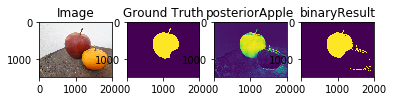

In [14]:
# Now run through the pixels in the image and classify them as being apple or
# non apple - we will fill in the posterior
priorApple =cOfApplePixels/(cOfApplePixels+cOfNonApplePixels)
priorNonApple =cOfNonApplePixels/(cOfApplePixels+cOfNonApplePixels)
imY, imX, imZ = ColorTestImgs[0].shape
posteriorApple = np.zeros((imY,imX))
# In order to get a binary result image.
binary=np.copy(posteriorApple)

for cY in range(imY): 
    for cX in range(imX):
        # Extract this pixel's data
        thisPixelData = np.double(ColorTestImgs[0][cY,cX,:])
        
        # Calculate likelihood of this data given apple model
        likeApple = calcGaussianProb(thisPixelData,ApplemixGaussEst);
        # Calculate likelihood of this data given non apple model
        likeNonApple = calcGaussianProb(thisPixelData,NonApplemixGaussEst );
        
        
        # Calculate posterior probability from likelihoods and priors using BAYES rule.
        # BAYES rule: Posterior=(Likelihood*Prior)/Evidence
        posteriorApple[cY][cX]=(likeApple*priorApple)/(likeApple*priorApple+likeNonApple*priorNonApple)
        # If posteriorApple > 0.5, it means the position is the location of apple. So we change the value to 1.
        # If posteriorApple <= 0.5, it means the position is not the location of apple. So we change the value to 0.
        if posteriorApple[cY][cX]>0.5:
            binary[cY][cX]=1
        if posteriorApple[cY][cX]<=0.5:
            binary[cY][cX]=0
    
# Set up plots
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
# Show the image
ax1.imshow(ColorTestImgs[0])
ax1.set_title('Image')
# Show the ground truth mask
ax2.imshow(MaskTestImgs[0])
ax2.set_title('Ground Truth')
# Show our prediction
ax3.imshow(posteriorApple)
ax3.set_title('posteriorApple')
# Show binary result
ax4.imshow(binary)
ax4.set_title('binaryResult')


In [15]:
# The first image is the original image, and the second image is ground truth image which just brighten 
# the apple. The third iamge is posterior image which aims to brighten the apple and darken other things
# and the fourth image is the binary result image which has same properties with ground truth image.
# The result fit my expectation-apple is bright and orange is dark.

Text(0.5,1,'binaryResult')

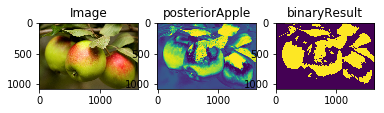

In [16]:
# Now run through the pixels in the image and classify them as being apple or
# non apple - we will fill in the posterior
priorApple =cOfApplePixels/(cOfApplePixels+cOfNonApplePixels)
priorNonApple =cOfNonApplePixels/(cOfApplePixels+cOfNonApplePixels)
imY, imX, imZ = ColorTestImgs[1].shape
posteriorApple = np.zeros((imY,imX))
# In order to get a binary result image.
binary=np.copy(posteriorApple)

for cY in range(imY): 
    for cX in range(imX):
        # Extract this pixel's data
        thisPixelData = np.double(ColorTestImgs[1][cY,cX,:])
        
        # Calculate likelihood of this data given skin model
        likeApple = calcGaussianProb(thisPixelData,ApplemixGaussEst);
        # Calculate likelihood of this data given non skin model
        likeNonApple = calcGaussianProb(thisPixelData,NonApplemixGaussEst );
        
        
        # Calculate posterior probability from likelihoods and priors using BAYES rule.
        # BAYES rule: Posterior=(Likelihood*Prior)/Evidence
        posteriorApple[cY][cX]=(likeApple*priorApple)/(likeApple*priorApple+likeNonApple*priorNonApple)
        # If posteriorApple > 0.5, it means the position is the location of apple. So we change the value to 1.
        # If posteriorApple <= 0.5, it means the position is not the location of apple. So we change the value to 0.
        if posteriorApple[cY][cX]>0.5:
            binary[cY][cX]=1
        if posteriorApple[cY][cX]<=0.5:
            binary[cY][cX]=0
    
# Set up plots
f, (ax1, ax2, ax3) = plt.subplots(1, 3)
# Show the image
ax1.imshow(ColorTestImgs[1])
ax1.set_title('Image')
# Show our prediction
ax2.imshow(posteriorApple)
ax2.set_title('posteriorApple')
# Show binary result
ax3.imshow(binary)
ax3.set_title('binaryResult')

In [17]:
# The first image is the original image. 
# The second iamge is posterior image which aims to brighten the apple and darken other things.
# The fourth image is the binary result image which has same properties with ground truth image.
# The results are not very accurate, because the color of leaves are similar with that of green apples.
# The leaves are recognized as apples.

Text(0.5,1,'binaryResult')

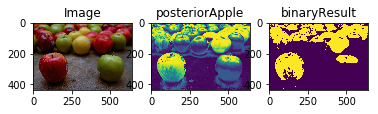

In [18]:
# Now run through the pixels in the image and classify them as being apple or
# non apple - we will fill in the posterior
priorApple =cOfApplePixels/(cOfApplePixels+cOfNonApplePixels)
priorNonApple =cOfNonApplePixels/(cOfApplePixels+cOfNonApplePixels)
imY, imX, imZ = ColorTestImgs[2].shape
posteriorApple = np.zeros((imY,imX))
# In order to get a binary result image.
binary=np.copy(posteriorApple)

for cY in range(imY): 
    for cX in range(imX):
        # Extract this pixel's data
        thisPixelData = np.double(ColorTestImgs[2][cY,cX,:])
        
        
        # Calculate likelihood of this data given skin model
        likeApple = calcGaussianProb(thisPixelData,ApplemixGaussEst);
        # Calculate likelihood of this data given non skin model
        likeNonApple = calcGaussianProb(thisPixelData,NonApplemixGaussEst );
        
        
        # Calculate posterior probability from likelihoods and priors using BAYES rule.
        # BAYES rule: Posterior=(Likelihood*Prior)/Evidence
        posteriorApple[cY][cX]=(likeApple*priorApple)/(likeApple*priorApple+likeNonApple*priorNonApple)
        # If posteriorApple > 0.5, it means the position is the location of apple. So we change the value to 1.
        # If posteriorApple <= 0.5, it means the position is not the location of apple. So we change the value to 0.
        if posteriorApple[cY][cX]>0.5:
            binary[cY][cX]=1
        if posteriorApple[cY][cX]<=0.5:
            binary[cY][cX]=0
    
# Set up plots.
f, (ax1, ax2, ax3) = plt.subplots(1, 3)
# Show the image
ax1.imshow(ColorTestImgs[2])
ax1.set_title('Image')
# Show our prediction
ax2.imshow(posteriorApple)
ax2.set_title('posteriorApple')
# Show binary result
ax3.imshow(binary)
ax3.set_title('binaryResult')

In [19]:
# The first image is the original image. 
# The second iamge is posterior image which aims to brighten the apple and darken other things.
# The fourth image is the binary result image which has same properties with ground truth image.
# The results fit my expectation-red apples are brighter than green apples, but yellow pears are darker than green apples.

# Calculate posterior probability and display results-test2Apples

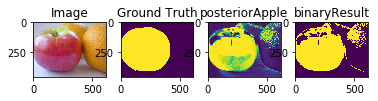

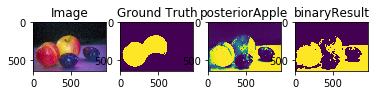

In [20]:
for i in range (len(ColorTest2Imgs)):
    # Now run through the pixels in the image and classify them as being apple or
    # non apple - we will fill in the posterior
    priorApple =cOfApplePixels/(cOfApplePixels+cOfNonApplePixels)
    priorNonApple =cOfNonApplePixels/(cOfApplePixels+cOfNonApplePixels)
    imY, imX, imZ = ColorTest2Imgs[i].shape
    posteriorApple = np.zeros((imY,imX))
    # In order to get a binary result image.
    binary=np.copy(posteriorApple)

    for cY in range(imY): 
        for cX in range(imX):
            # Extract this pixel's data
            thisPixelData = np.double(ColorTest2Imgs[i][cY,cX,:])
        
            # Calculate likelihood of this data given apple model
            likeApple = calcGaussianProb(thisPixelData,ApplemixGaussEst);
            # Calculate likelihood of this data given non apple model
            likeNonApple = calcGaussianProb(thisPixelData,NonApplemixGaussEst );
        
        
            # Calculate posterior probability from likelihoods and priors using BAYES rule.
            # BAYES rule: Posterior=(Likelihood*Prior)/Evidence
            posteriorApple[cY][cX]=(likeApple*priorApple)/(likeApple*priorApple+likeNonApple*priorNonApple)
            # If posteriorApple > 0.5, it means the position is the location of apple. So we change the value to 1.
            # If posteriorApple <= 0.5, it means the position is not the location of apple. So we change the value to 0.
            if posteriorApple[cY][cX]>0.5:
                binary[cY][cX]=1
            if posteriorApple[cY][cX]<=0.5:
                binary[cY][cX]=0
    
    # Set up plots
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
    # show the image
    ax1.imshow(ColorTest2Imgs[i])
    ax1.set_title('Image')
    # Show the ground truth mask
    ax2.imshow(MaskTest2Imgs[i])
    ax2.set_title('Ground Truth')
    # Show our prediction
    ax3.imshow(posteriorApple)
    ax3.set_title('posteriorApple')
    # Show binary result
    ax4.imshow(binary)
    ax4.set_title('binaryResult')

In [21]:
# The first image is the original image. 
# The second iamge is posterior image which aims to brighten the apple and darken other things.
# The fourth image is the binary result image which has same properties with ground truth image.
# The first image test results is accurate-apple is bright and orange is dark.
# However we can know the second image test results are not very accurate from comparing ground truth image and binary result image.